In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
import csv

# ---------------------------
# Hyperparameters
# ---------------------------
BATCH_SIZE = 32         # Number of sequences per batch
BLOCK_SIZE = 64         # Maximum context length
MAX_ITERS = 5000        # Total number of training iterations
EVAL_INTERVAL = 500     # Evaluation interval (in iterations)
LEARNING_RATE = 1e-3    # Learning rate
N_EMBD = 128            # Embedding dimension
N_HEAD = 4              # Number of attention heads
N_LAYER = 6             # Number of Transformer layers
DROPOUT = 0             # Dropout rate

# Initial number of parameter tokens per attention head (for Pattention)
INIT_PARAM_TOKENS = 128

# Progressive scaling schedule:
# At specified iteration numbers, expand the number of parameter tokens.
SCALING_SCHEDULE = {1000: 512, 2000: 1024, 3000: 2048, 4000: 5096}

# ---------------------------
# Device Selection
# ---------------------------
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
torch.manual_seed(1337)

EVAL_ITERS = 200

# Global training start time (used for timing logs)
global_start_time = time.time()

##########################
# TokenFormer Pattention Modules
##########################

class TokenFormerHead(nn.Module):
    """
    A Pattention head that uses learnable parameter tokens to compute keys and values.
    - Query: computed from the input tokens.
    - Keys and Values: computed from a set of learnable parameter tokens.
    """
    def __init__(self, head_size, num_param_tokens):
        super().__init__()
        self.query = nn.Linear(N_EMBD, head_size, bias=True)
        # Learnable parameter tokens for keys and values
        self.KP = nn.Parameter(torch.randn(num_param_tokens, head_size))
        self.VP = nn.Parameter(torch.randn(num_param_tokens, head_size))
        self.dropout = nn.Dropout(DROPOUT)
        self.scale = head_size ** -0.5

    def forward(self, x):
        # x: (B, T, N_EMBD)
        B, T, _ = x.shape
        q = self.query(x)  # (B, T, head_size)
        attn_scores = q @ self.KP.T * self.scale  # (B, T, num_param_tokens)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        out = attn_weights @ self.VP  # (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module based on Pattention.
    """
    def __init__(self, num_heads, head_size, num_param_tokens):
        super().__init__()
        self.heads = nn.ModuleList([
            TokenFormerHead(head_size, num_param_tokens) for _ in range(num_heads)
        ])
        self.proj = nn.Linear(head_size * num_heads, N_EMBD)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        head_outputs = [head(x) for head in self.heads]
        concatenated = torch.cat(head_outputs, dim=-1)
        out = self.dropout(self.proj(concatenated))
        return out

##########################
# Pattention-based Feed-Forward Module
##########################

class PattentionFFN(nn.Module):
    """
    A feed-forward module based on Pattention.
    It replaces the traditional MLP with two consecutive Pattention layers.
    A LayerNorm is applied at the beginning, and a residual connection is added.
    """
    def __init__(self, n_embd, num_param_tokens):
        super().__init__()
        self.ln = nn.LayerNorm(n_embd)
        # Using two consecutive Pattention layers (each implemented as a TokenFormerHead)
        # Here, we set the output dimension equal to n_embd so that no additional projection is required.
        self.pattn1 = TokenFormerHead(n_embd, num_param_tokens)
        self.pattn2 = TokenFormerHead(n_embd, num_param_tokens)
        self.dropout = nn.Dropout(DROPOUT)
    
    def forward(self, x):
        residual = x
        x = self.ln(x)
        x = self.pattn1(x)
        x = self.pattn2(x)
        x = self.dropout(x)
        return residual + x

##########################
# Other Module Definitions
##########################

class Block(nn.Module):
    """
    A Transformer block consisting of:
      - A multi-head attention layer (based on Pattention)
      - A feed-forward network (using Pattention-based FFN)
    Both sub-layers use residual connections.
    """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, INIT_PARAM_TOKENS)
        # Replace traditional FFN with our PattentionFFN module
        self.ffwd = PattentionFFN(n_embd, INIT_PARAM_TOKENS)
        self.ln1 = nn.LayerNorm(n_embd)
        # Note: the feed-forward block (PattentionFFN) already includes normalization, so no separate ln2 here.
    
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(x)
        return x

class GPTLanguageModel(nn.Module):
    """
    A GPT-style language model.
    """
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, N_EMBD)
        self.position_embedding_table = nn.Embedding(BLOCK_SIZE, N_EMBD)
        self.blocks = nn.Sequential(*[Block(N_EMBD, n_head=N_HEAD) for _ in range(N_LAYER)])
        self.ln_f = nn.LayerNorm(N_EMBD)
        self.lm_head = nn.Linear(N_EMBD, vocab_size)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -BLOCK_SIZE:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

##########################
# Progressive Scaling
##########################

def progressive_scale_model(model, new_num_param_tokens):
    """
    Expand the parameter tokens (used in Pattention) in all TokenFormerHead modules.
    The new tokens are zero-initialized.
    """
    for block in model.blocks:
        for head in block.sa.heads:
            old_KP, old_VP = head.KP, head.VP
            old_num = old_KP.shape[0]
            if new_num_param_tokens <= old_num:
                continue
            head_size = old_KP.shape[1]
            extra_KP = torch.zeros(new_num_param_tokens - old_num, head_size, device=old_KP.device)
            extra_VP = torch.zeros(new_num_param_tokens - old_num, head_size, device=old_VP.device)
            head.KP = nn.Parameter(torch.cat([old_KP, extra_KP], dim=0))
            head.VP = nn.Parameter(torch.cat([old_VP, extra_VP], dim=0))
    
    elapsed_total = time.time() - global_start_time
    total_params = sum(p.numel() for p in model.parameters())
    print("\n========== Scaling Event ==========")
    print(f"Cumulative training time: {elapsed_total:.2f} seconds")
    print(f"Parameter tokens per head expanded to: {new_num_param_tokens}")
    print(f"Total model parameters now: {total_params/1e6:.2f} M")
    print("===================================\n")
    return model

##########################
# Data Loading and Preprocessing
##########################

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    chars = sorted(list(set(text)))
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    return data, stoi, itos, decode

def create_data_splits(data, train_ratio=0.9):
    n = int(train_ratio * len(data))
    return data[:n], data[n:]

def get_batch(data, block_size, batch_size):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def evaluate_model(model, data, block_size, eval_iters):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        xb, yb = get_batch(data, block_size, BATCH_SIZE)
        _, loss = model(xb, yb)
        losses[k] = loss.item()
    avg_loss = losses.mean().item()
    model.train()
    return avg_loss, math.exp(avg_loss)

##########################
# Main Training Function
##########################

def train_model():
    # Load data and create splits
    data, stoi, itos, decode = load_data('pokemon.txt')
    vocab_size = len(stoi)
    train_data, val_data = create_data_splits(data)
    total_input_tokens = len(train_data)
    print(f"Total input tokens in training data: {total_input_tokens}")

    # Initialize model
    model = GPTLanguageModel(vocab_size).to(device)
    print(f"Initial model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f} M parameters")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    total_training_tokens = 0
    logs = []
    current_param_tokens = INIT_PARAM_TOKENS

    # Progressive scaling schedule is defined in SCALING_SCHEDULE
    global global_start_time
    global_start_time = time.time()

    for iter in range(MAX_ITERS):
        # Check if a scaling event is scheduled
        if iter in SCALING_SCHEDULE:
            new_token_count = SCALING_SCHEDULE[iter]
            model = progressive_scale_model(model, new_token_count)
            current_param_tokens = new_token_count

        xb, yb = get_batch(train_data, BLOCK_SIZE, BATCH_SIZE)
        total_training_tokens += xb.shape[0] * xb.shape[1]

        if iter % EVAL_INTERVAL == 0 or iter == MAX_ITERS - 1:
            loss_val, ppl_val = evaluate_model(model, train_data, BLOCK_SIZE, EVAL_ITERS)
            elapsed = time.time() - global_start_time
            log_line = [iter, loss_val, ppl_val, current_param_tokens, total_training_tokens]
            logs.append(log_line)
            print(f"Iter {iter}: Loss {loss_val:.4f}, Perplexity {ppl_val:.4f}, "
                  f"Param Tokens per Head {current_param_tokens}, Total Training Tokens {total_training_tokens}, "
                  f"Cumulative Time {elapsed:.2f} sec")
        
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    total_time = time.time() - global_start_time
    print(f"\nTotal training time: {total_time:.2f} seconds.")
    print(f"Total training tokens processed: {total_training_tokens}")

    # Save logs to CSV
    csv_filename = "training_log.csv"
    with open(csv_filename, mode="w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["iteration", "loss", "perplexity", "param_tokens", "total_training_tokens"])
        for log in logs:
            csv_writer.writerow(log)
    print(f"Training log saved to {csv_filename}")

    # Generate sample text
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    generated = model.generate(context, max_new_tokens=500)[0].tolist()
    print("\nGenerated Text:")
    print(decode(generated))

if __name__ == '__main__':
    train_model()


Total input tokens in training data: 458319
Initial model parameters: 1.02 M parameters
Iter 0: Loss 4.4805, Perplexity 88.2766, Param Tokens per Head 128, Total Training Tokens 2048, Cumulative Time 3.61 sec
Iter 500: Loss 2.4140, Perplexity 11.1788, Param Tokens per Head 128, Total Training Tokens 1026048, Cumulative Time 56.15 sec


KeyboardInterrupt: 

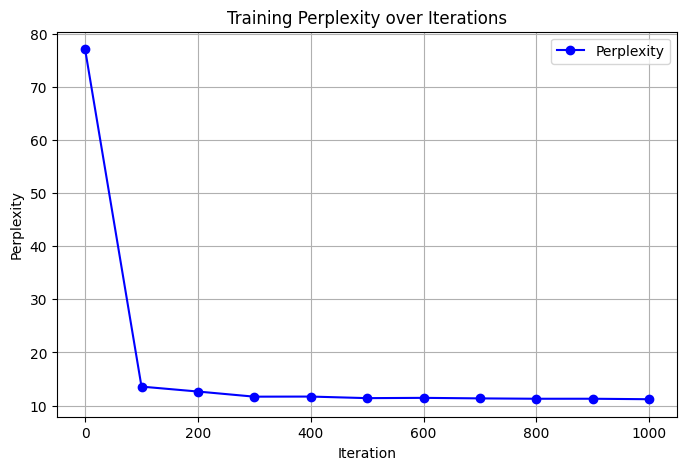

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
df = pd.read_csv("training_log.csv")

# 绘制图表
plt.figure(figsize=(8, 5))
plt.plot(df["iteration"], df["perplexity"], marker="o", linestyle="-", color="b", label="Perplexity")

# 添加标题和标签
plt.title("Training Perplexity over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)

# 显示图表
plt.show()
